# Semi-supervised classification of German press releases

This script is based on: https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_newsgroups.html


In [ ]:
# import sklearn; sklearn.show_versions()
# !pip install --upgrade scikit-learn

In [ ]:
# Load packages
import os
import numpy as np
import pandas as pd
from google.colab import drive
import timeit

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
# Set up wd
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/scripts-hu/issues/semi-files')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("alldocs.csv")


In [ ]:
df.columns

Index(['issue_r1', 'id', 'country', 'party', 'date', 'cv_sample', 'htext'], dtype='object')

In [ ]:
# Load press release data (training and test)
alldata =  df['htext'].values
alltarget = df['issue_r1'].values
cv_sample = df[alltarget != -1]['cv_sample'].values


In [ ]:
# Only take labeled 
X = alldata[alltarget != -1]
y = alltarget[alltarget != -1]

In [ ]:
# Evaluation function
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("Accuracy: "
          "%0.3f" % accuracy_score(y_test, y_pred))
    print("-" * 10)
    print()


### The (non-semi) base classifier

bigrams and max_docfreq 0.06
elasticnet
test_size 20%

In [ ]:
# Create train/test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[cv_sample != 1]
y_train = y[cv_sample != 1]

X_test = X[cv_sample == 1]
y_test = y[cv_sample == 1]

In [ ]:
# Define parameters for vectorizer and classifier
vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.06)
sgd_params = dict(alpha=8e-5, penalty='elasticnet', l1_ratio = .5, loss='log', random_state = 1621447882)

# Supervised Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(**vectorizer_params)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(**sgd_params)),
])

# Fit and evaluate
eval_and_print_metrics(pipeline, X_train, y_train, X_test, y_test)

Number of training samples: 2098
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.704
Accuracy: 0.704
----------



### The semi-supervised classifier
With 5,000 unlabelled
Testint different thresholds

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

thresholds = [.2, .3, .4, .5, .6, .7, .8, .9, .95, .99]

results = []

# Leave test sample
X_all = alldata[df['cv_sample'].values != 1]
y_all = alltarget[df['cv_sample'].values != 1]

for i in thresholds:
  print(i)

  sgd_params = dict(alpha=8e-5, penalty='elasticnet', l1_ratio = .5, loss='log', random_state = 1621447882)
  vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.06)
  stc_params = dict(verbose=True, criterion = "threshold", threshold = i) #  k_best = 1000)
  
  # SelfTraining Pipeline
  st_pipeline = Pipeline([
    ('vect', CountVectorizer(**vectorizer_params)),
    ('tfidf', TfidfTransformer()),
    ('clf', SelfTrainingClassifier(SGDClassifier(**sgd_params), **stc_params)),
    ])
  
  clf = st_pipeline
  clf.fit(X_all, y_all)
  y_pred = clf.predict(X_test)
 
  print(accuracy_score(y_test, y_pred))
  results.append(accuracy_score(y_test, y_pred))


0.2
End of iteration 1, added 26351 new labels.
End of iteration 2, added 8073 new labels.
End of iteration 3, added 7349 new labels.
End of iteration 4, added 561 new labels.
End of iteration 5, added 3 new labels.
0.4085603112840467
0.3
End of iteration 1, added 16801 new labels.
End of iteration 2, added 7858 new labels.
End of iteration 3, added 8015 new labels.
End of iteration 4, added 9179 new labels.
End of iteration 5, added 464 new labels.
End of iteration 6, added 5 new labels.
0.30739299610894943
0.4
End of iteration 1, added 10041 new labels.
End of iteration 2, added 7455 new labels.
End of iteration 3, added 4471 new labels.
End of iteration 4, added 14331 new labels.
End of iteration 5, added 5867 new labels.
End of iteration 6, added 137 new labels.
End of iteration 7, added 3 new labels.
0.2529182879377432
0.5
End of iteration 1, added 4957 new labels.
End of iteration 2, added 5590 new labels.
End of iteration 3, added 3364 new labels.
End of iteration 4, added 4340 

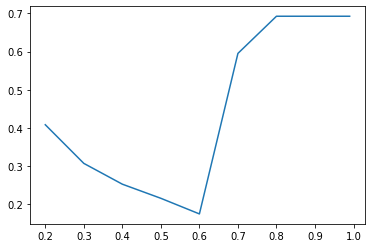

In [ ]:
import matplotlib.pyplot as plt
plt.plot(thresholds, results)

In [ ]:
results

[0.4085603112840467,
 0.30739299610894943,
 0.2529182879377432,
 0.21595330739299612,
 0.17509727626459143,
 0.5953307392996109,
 0.6926070038910506,
 0.6926070038910506,
 0.6926070038910506,
 0.6926070038910506]

In [ ]:
results = pd.DataFrame({'accuracy': results, 'threshold': thresholds})
np.savetxt("results-thresholds.csv", results, delimiter = ",")

### Optimal model
Five-fold cross-validation

In [ ]:
# Prepare five-fold cross-validation

# Define parameters
sgd_params = dict(alpha=8e-5, penalty='elasticnet', l1_ratio = .5, loss='log', random_state = 1621447882)
vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.06)
stc_params = dict(verbose=True, criterion = "threshold", threshold = .95)

# SelfTraining Pipeline
st_pipeline = Pipeline([
                        ('vect', CountVectorizer(**vectorizer_params)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SelfTrainingClassifier(SGDClassifier(**sgd_params), **stc_params)),
                        ])

# Create a list to store the data of each fold
results = []
times = []
semi_pred = pd.DataFrame()

# Loop over all folds (5)
for i in [1, 2, 3, 4, 5]:
  print(i)
  
  # Create train/test data
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train = alldata[df['cv_sample'].values != i]
  y_train = alltarget[df['cv_sample'].values != i]
  
  X_test = X[cv_sample == i]
  y_test = y[cv_sample == i]
  
  clf = st_pipeline
  
  start = timeit.default_timer()
  clf.fit(X_train, y_train)

  # Add the time to the list
  stop = timeit.default_timer()
  times.append((stop - start))

  y_pred = clf.predict(X_test)
  
  print(accuracy_score(y_test, y_pred))
  
  # Add the accuracy to the list
  results.append(accuracy_score(y_test, y_pred))

  this_semi_pred = pd.DataFrame({'prediction': y_pred,
                                 'issue_r1': y_test,
                                 'cv_sample': i},
                                index = list(range(0, len(y_test))))
  print(this_semi_pred)

  semi_pred = semi_pred.append(this_semi_pred)
                   
  np.savetxt("semi-pred.csv", semi_pred, delimiter = ",")



1
0.6926070038910506
     prediction  issue_r1  cv_sample
0             1         1          1
1             1         1          1
2             1         1          1
3             1         1          1
4             1         1          1
..          ...       ...        ...
509         192       192          1
510          10       192          1
511          15       192          1
512         191       192          1
513         192       192          1

[514 rows x 3 columns]
2
0.6384615384615384
     prediction  issue_r1  cv_sample
0             1         1          2
1           191         1          2
2             1         1          2
3           191         1          2
4             5         1          2
..          ...       ...        ...
515         192       192          2
516          15       192          2
517         192       192          2
518         192       192          2
519         192       192          2

[520 rows x 3 columns]
3
0.6910420475319927
 

In [ ]:
print(f'Average accuracy: {sum(results)/5}')

Average accuracy: 0.6678500055955482


In [ ]:
np.savetxt("cv-accuracy.txt", [sum(results)/5], delimiter = ",")
np.savetxt("cv-time.txt", [sum(times)/5], delimiter = ",")